# Portfolio Project: E-commerce Customer Analysis - Understanding Behavior and Identifying High-value Segments

Note: The data used in this project is publically available and can be found here: https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci

## Project Objective:

The goal of this project is to analyze customer purchasing behavior in the Online Retail II dataset and to identify patterns that drive revenue:

* Understand overall sales trends: which products, countries, and time periods contribute most to revenue?
* Profile customer purchasing behavior: How often do customers purchase and how much to they spend?
* Segment customers by value - How can recency, frequency, and monetary analysis distinguish high-value customers from lower-value ones? 
* Determine insights - review opportunities for customer retention, marketing strategies, and growth

This analysis will showcase core data science skills, including:
* data cleaning
* exploratory analysis
* visualization
* customer segmentation using RFM analysis
* customer segmentation using clustering (unsupervised Machine Learning)
* communication of actionable insights

Let's get started. We'll begin by loading some basic libraries and checking the structure of our dataset.

## Pt 1 - Structure of the Data

Here, we'll simply load the dataset and see what it looks like.

(Note: you may want to change the 'os.environ' line to the number of cores on your computer, or just comment it out altogether. Everything will function fine, but you will get an insignificant error when using sklearn later in the project)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["LOKY_MAX_CPU_COUNT"]  = "8"

#loading the dataset
data = pd.read_csv('online_retail_II.csv')

#viewing the dataset
data.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
#viewing column info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


The datatype for InvoiceDate is wrong. We can fix that easily:

In [6]:
#switch dates/times to the correct datatype
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB
None


## Pt 2 - Preparing the Data

### Pt 2.1: Examining the data

Now, we're going to need to examine and clean the data. What are some summary statistics we can understand immediately? How many missing entries are there in each column? Do we want to remove these entries? Are there any duplicates?

In [8]:
#summary statistics
data.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,1.067371e+06,1067371,1.067371e+06,824364.000000
mean,9.938898e+00,2011-01-02 21:13:55.394028544,4.649388e+00,15324.638504
min,-8.099500e+04,2009-12-01 07:45:00,-5.359436e+04,12346.000000
25%,1.000000e+00,2010-07-09 09:46:00,1.250000e+00,13975.000000
50%,3.000000e+00,2010-12-07 15:28:00,2.100000e+00,15255.000000
75%,1.000000e+01,2011-07-22 10:23:00,4.150000e+00,16797.000000
max,8.099500e+04,2011-12-09 12:50:00,3.897000e+04,18287.000000
std,1.727058e+02,NaN,1.235531e+02,1697.464450


Notice the very large outliers for the min and max values of both the unit price and Quantity. Large quantities make sense for an online retailer, but we'll remove negative values later to focus on site income rather than customer returns (may be valuable for another analysis).

Below, we'll rename the Customer ID column for ease of use, and then check the percentage of null values in each column.

In [10]:
#rename Customer ID for ease of use
data.rename(columns = {'Customer ID' : 'CustomerID'}, inplace = True)

#check each column for missing values as a percentage
print(100*data.isnull().sum()/data.shape[0])

Invoice         0.000000
StockCode       0.000000
Description     0.410541
Quantity        0.000000
InvoiceDate     0.000000
Price           0.000000
CustomerID     22.766873
Country         0.000000
dtype: float64


**So about 0.41% of Descriptions are null and 22.76% of CustomerID entries are null. We'll fix this as well.**

#### Pt 2.2: Cleaning the data

Now we need to
* Look for duplicate rows and delete them
* standardize the descriptions column (could fix entries that were capitalized or formatted differently)
* remove negative values from the Quantity and price columns (falsely negative unit prices, customer returns)
* remove null values, which appear in the Description and CustomerID columns

In [13]:
#making a column of duplicates. True = duplicated data
duplicates = data.duplicated().reset_index()
print('Starting number of duplicates: ', duplicates[0].sum())

# to remove duplicates if there were any
data = data.drop_duplicates().reset_index()

duplicates = data.duplicated().reset_index()
print('Ending number of duplicates: ', duplicates[0].sum())

Starting number of duplicates:  34335
Ending number of duplicates:  0


There were quite a few duplicate values, but they're gone now. Now let's give the 'InvoiceDate' column the correct data type.

In [15]:
#switch dates/times to the correct datatype
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1033036 entries, 0 to 1033035
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   index        1033036 non-null  int64         
 1   Invoice      1033036 non-null  object        
 2   StockCode    1033036 non-null  object        
 3   Description  1028761 non-null  object        
 4   Quantity     1033036 non-null  int64         
 5   InvoiceDate  1033036 non-null  datetime64[ns]
 6   Price        1033036 non-null  float64       
 7   CustomerID   797885 non-null   float64       
 8   Country      1033036 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 70.9+ MB
None


Now we should make sure all the descriptions have a similar style. Since the first few entries are all uppercase, we'll stick with that for the whole dataset. We should also remove any extra whitespace.

In [17]:
#remove extra whitespace, make all letters uppercase
data['Description'] = data['Description'].str.strip().str.upper()
print(data['Description'])

0          15CM CHRISTMAS GLASS BALL 20 LIGHTS
1                           PINK CHERRY LIGHTS
2                          WHITE CHERRY LIGHTS
3                  RECORD FRAME 7" SINGLE SIZE
4               STRAWBERRY CERAMIC TRINKET BOX
                          ...                 
1033031            CHILDREN'S APRON DOLLY GIRL
1033032           CHILDRENS CUTLERY DOLLY GIRL
1033033        CHILDRENS CUTLERY CIRCUS PARADE
1033034           BAKING SET 9 PIECE RETROSPOT
1033035                                POSTAGE
Name: Description, Length: 1033036, dtype: object


Next we need to remove negative values. The scope of this analysis will be on customer purchases rather than returns, so we will remove negative "Quantity" values. In addition, negative values for unit-price don't make sense, so we will remove those as well.

After removing negative values, we'll also remove extreme outliers. As an online wholesaler, it makes sense to have some very-large values for quantity, but we'll limit to a unit price below $20,000. 

Along with these adjustments to the data we'll plot some simple histograms (before and after) to get a quick view of what the distribution of prices and order quantities look like. 

**(NOTE: because both distributions are highly concentrated around lower values, we'll use a logarithmic scale to clearly see larger values that apply to fewer transactions. If you're unfamiliar with a logarithmic scale - take a look at the y axis on these plots, and you'll see that each step upward is an order of magnitude higher:** $10^1$, $10^2$, **etc..., which means that a bar that is twice the size of another is actually orders of magnitude larger!)**

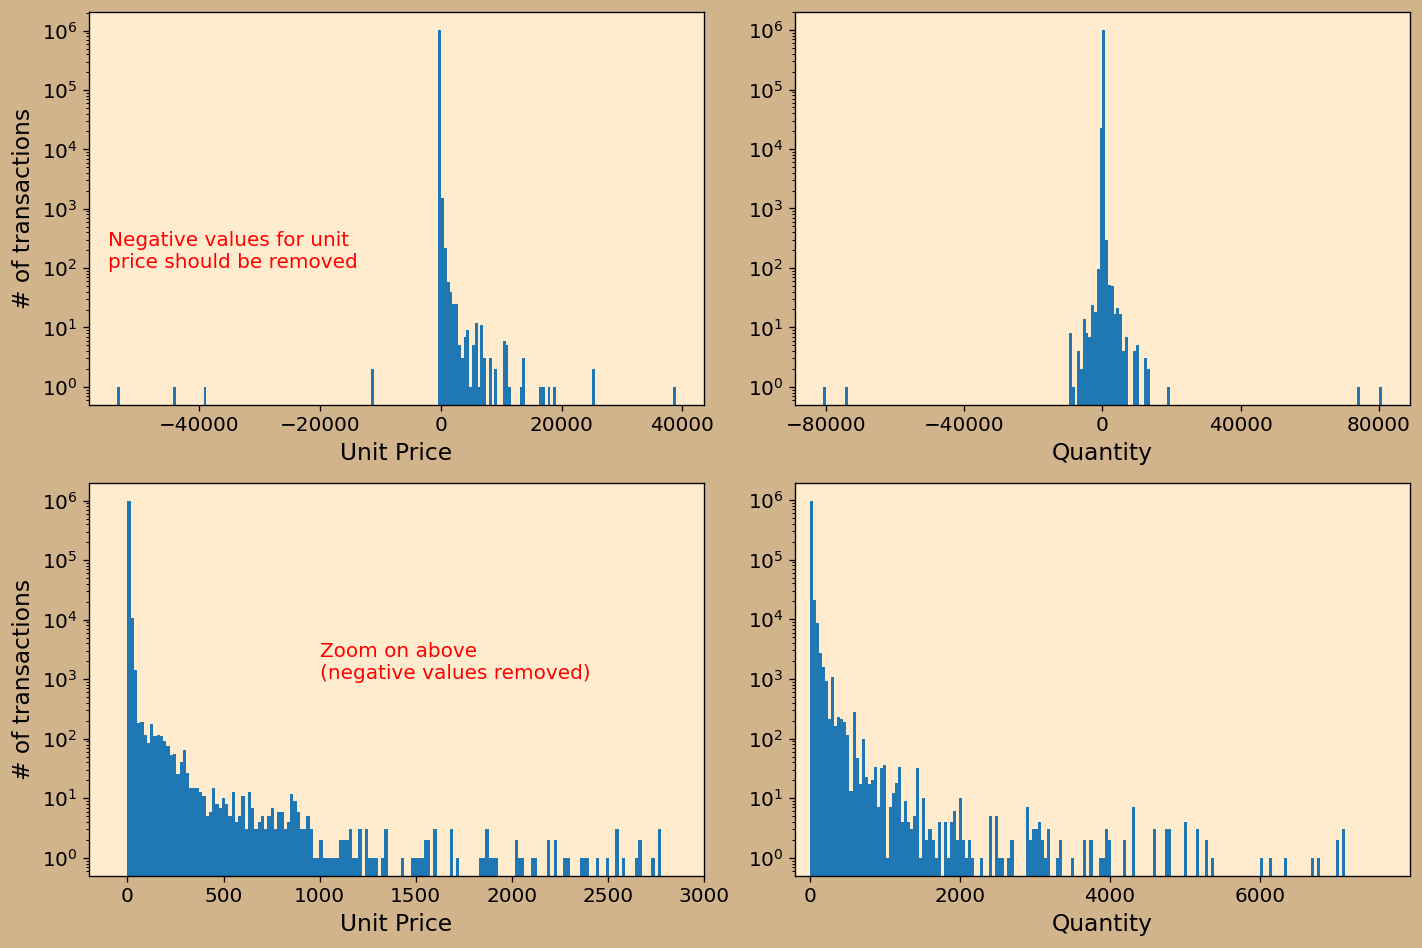

In [19]:
fig = plt.figure(figsize=(12,8),dpi=120)
fig.patch.set_facecolor('tan')
ax1 = plt.subplot(2,2,1)
ax1.set_yscale('log')
#ax1.annotate(-5,20,"Negative values for unit price \n should be removed")
ax1.text(-55000,100, "Negative values for unit \nprice should be removed", fontsize = 12, color = 'r')
ax1.patch.set_facecolor('blanchedalmond')
plt.hist(data['Price'], bins=200)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.ylabel('# of transactions', fontsize = 14)
plt.xlabel('Unit Price', fontsize=14)
ax2 = plt.subplot(2,2,2)
ax2.set_yscale('log')
ax2.patch.set_facecolor('blanchedalmond')
plt.xlabel('Quantity', fontsize=14)
plt.yticks(fontsize = 12)
plt.xticks(np.arange(-80000,120000,40000),fontsize = 12)
plt.hist(data['Quantity'], bins=200)


#This is an online wholesaler, so it doesn't make sense to remove large quantity values. 
#Unit price, however, should not be negative. We'll also ignore negative "Quantity" values
#in order to focus on purchases rather than returns or cancellations.

data_final = data[(data['Price']>0) & (data['Quantity']>0)].reset_index(drop=True)

#to remove outliers, we'll remove extreme values from unit price. Most of the distribution os
#to be below $20000, so we'll remove values above that
data_final = data_final[(data_final['Price']<20000)].reset_index(drop=True)


ax3 = plt.subplot(2,2,3)
ax3.set_yscale('log')
ax3.patch.set_facecolor('blanchedalmond')
ax3.text(1000,1000, "Zoom on above \n(negative values removed)", fontsize = 12, color = 'r')
plt.xlim([-200,3000])
plt.hist(data_final['Price'], bins=800)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.xlabel('Unit Price', fontsize=14)
plt.ylabel('# of transactions', fontsize = 14)
ax4 = plt.subplot(2,2,4)
ax4.set_yscale('log')
ax4.patch.set_facecolor('blanchedalmond')
plt.xlim([-200,8000])
plt.hist(data_final['Quantity'], bins=2000)
plt.yticks(fontsize = 12)
plt.xticks(np.arange(0,8000,2000),fontsize = 12)
plt.xlabel('Quantity', fontsize=14)
plt.tight_layout()
plt.show()
#data.describe()

The final step before we can begin our exploratory data analysis is removal of null values in the "Description" and "CustomerID" columns. After that removal, we'll check that everything looks correct before moving on.

In [21]:
#removing null values from the clean dataset
data_final = data_final.dropna(subset=['CustomerID','Description']).reset_index(drop=True)


print('Null percentages after above step: \n')
print(100*data_final.isnull().sum()/data_final.shape[0], '\n')

Null percentages after above step: 

index          0.0
Invoice        0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
Price          0.0
CustomerID     0.0
Country        0.0
dtype: float64 



We now have a clean dataset to work with. In the next steps, we'll begin an exploratory analysis of the data.

## Pt 3: Exploratory Analysis

We'll take a few steps to get a better understanding of the data in relation to our online Ecommerce business. These will include:

* total revenue
* number of orders
* median order value (median less affected by outliers)
* median order cost
* top products and countries
* revenue tracked per month

We'll first add a column that includes the total cost of each transaction:

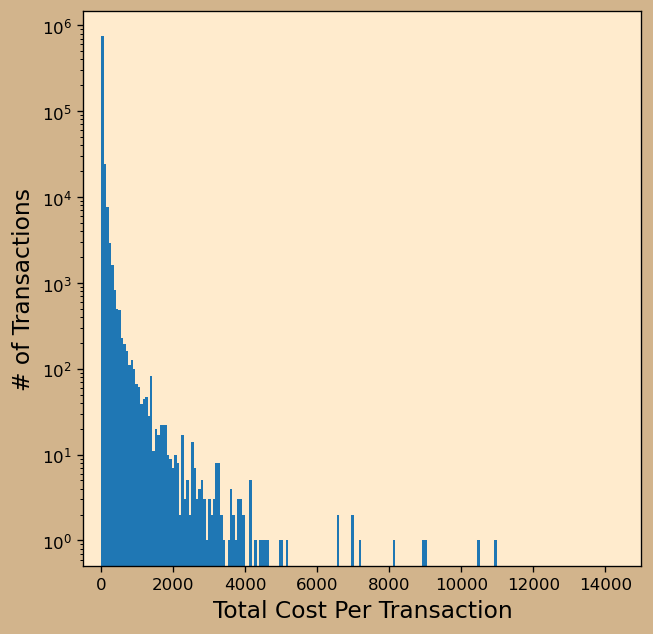

In [23]:
#creating new column representing the total price for each order
data_final['TotalPrice'] = data_final['Quantity']*data_final['Price']
#.apply(lambda row: row['Quantity']*row['Price'],axis=1)

fig = plt.figure(figsize=(6,6),dpi=120)
fig.patch.set_facecolor('tan')
ax1 = plt.subplot(1,1,1)
ax1.set_yscale('log')
ax1.patch.set_facecolor('blanchedalmond')
#there are a few extreme values, but we'll just look at the bulk of the distribution:
plt.xlim([-500,15000])
plt.hist(data_final['TotalPrice'], bins=2500)
plt.xlabel('Total Cost Per Transaction', fontsize = 14)
plt.ylabel('# of Transactions', fontsize = 14)
plt.show()

And now we'll calculate the total revenue, number of items sold, mean/median order quantity, mean/median order cost, top products and top countries in terms of number of orders:

In [25]:
total_revenue = data_final['TotalPrice'].sum() #sum of order cost
num_items = data['Quantity'].sum() #sum of order quantity
quantity_median = data_final['Quantity'].median() #quantity median
cost_median = data_final['TotalPrice'].median() #order price median
quantity_mean = data_final['Quantity'].mean() #quantity mean
cost_mean = data_final['TotalPrice'].mean() #order price mean

mil = 1000000 #one million

#printing all of the calculated information below
print(f"The total revenue based on purchases is: {(total_revenue/mil):.3f} million dollars.")
print(f'The total number of items sold is : {(num_items/mil):.3f} million dollars.')

print(f'''
The mean and median for quantity of items per purchase is: {quantity_mean:.3f} dollars
and {quantity_median:.3f} dollars.
    ''')

print(f'''
The mean and median for the price of each transaction is: {cost_mean:3f} dollars
and {cost_median:.3f} dollars. 
''')

The total revenue based on purchases is: 17.375 million dollars.
The total number of items sold is : 10.410 million dollars.

The mean and median for quantity of items per purchase is: 13.489 dollars
and 6.000 dollars.
    

The mean and median for the price of each transaction is: 22.291823 dollars
and 12.480 dollars. 



We now have the **total revenue** and number of items sold for our Ecommerce business. We also have the **mean and median** of item quantity and revenue made from individual purchases. Both show that the higher-cost and higher-quantity purchases bring up the average, with mean values at least double the median, which can be considered the typical purchase quantity/price.

The top ten products bring in the most revenue are: 
 
 Description
REGENCY CAKESTAND 3 TIER              277656.25
WHITE HANGING HEART T-LIGHT HOLDER    247048.01
PAPER CRAFT , LITTLE BIRDIE           168469.60
MANUAL                                151777.67
JUMBO BAG RED RETROSPOT               134307.44
POSTAGE                               124648.04
ASSORTED COLOUR BIRD ORNAMENT         124351.86
PARTY BUNTING                         103283.38
MEDIUM CERAMIC TOP STORAGE JAR         81416.73
PAPER CHAIN KIT 50'S CHRISTMAS         76598.18
Name: TotalPrice, dtype: float64 


Plot of revenue percentages per country (top 10):


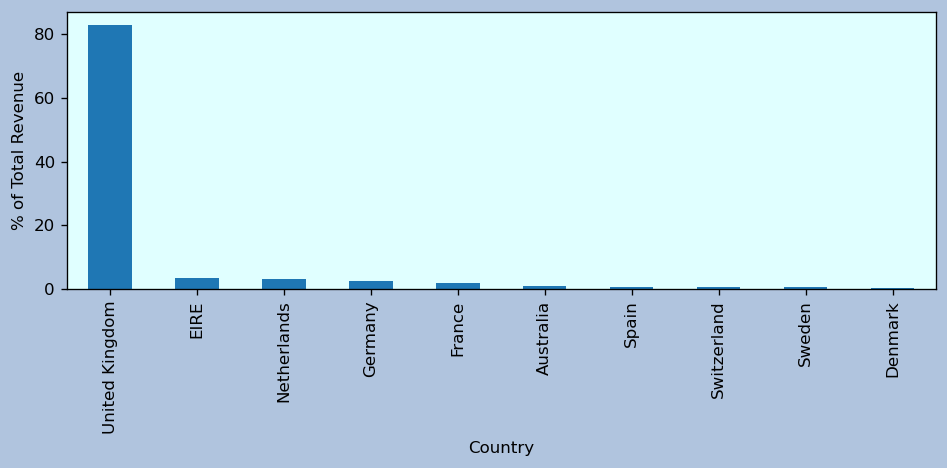

In [61]:
#calculation and printing of the top products and top countries
top_products = data_final.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10)
print('The top ten products bring in the most revenue are: \n \n', top_products, '\n\n')

top_countries = data_final.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)
percent_total = 100.0*top_countries/total_revenue

print('Plot of revenue percentages per country (top 10):')

fig = plt.figure(figsize=(8,4),dpi=120)
fig.patch.set_facecolor('lightsteelblue')
ax1 = percent_total.plot(kind='bar')
ax1.patch.set_facecolor('lightcyan')
plt.ylabel('% of Total Revenue')
plt.tight_layout()
plt.show()




The **products that have generated the most revenue** are above, with the top three being the "Regency 3-tier cakestand", a "Manual" and "Dotcom postage". The countries with the highest revenue are the United Kingdom, EIRE, and the Netherlands. It's worth noting that EIRE refers to transactions coming out of Ireland. It's also worth noting that about **85% of the total income comes from the UK**, with the 2nd and 3rd place countries trailing at 3.22% and 2.71%.

Next we'll plot the **revenue per month** to explore any yearly trends in customer spending:

In [29]:
data_final.set_index('InvoiceDate',inplace=True) #use date as primary index
monthly_revenue = data_final['TotalPrice'].resample('ME').sum() #sum money spent per month

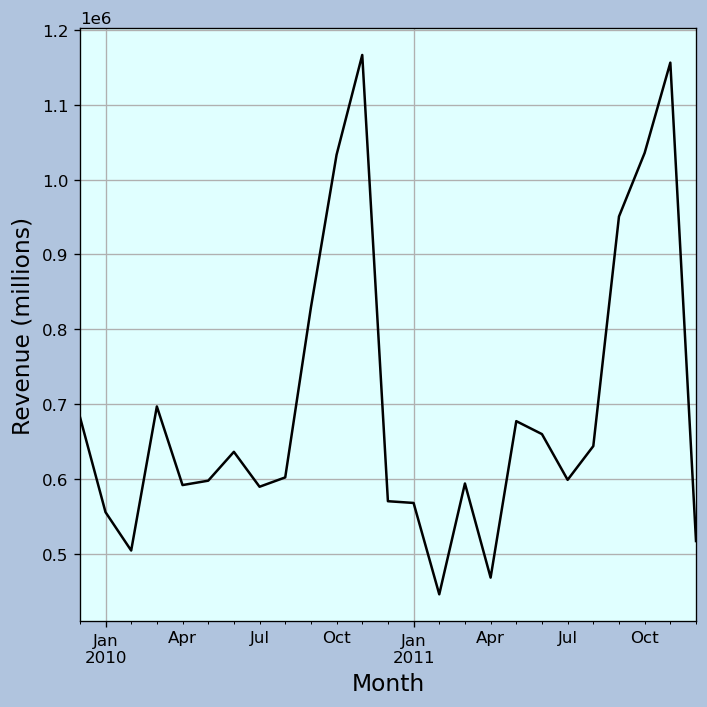

In [63]:
import matplotlib as matplot

#plot money spent per month
fig = plt.figure(figsize=(6,6),dpi=120)
fig.patch.set_facecolor('lightsteelblue')
ax = monthly_revenue.plot(kind='line',color='k')
ax.patch.set_facecolor('lightcyan')
plt.ylabel('Revenue (millions)',fontsize=14)
plt.xlabel('Month',fontsize=14)
plt.grid()
plt.tight_layout()
plt.show()



A clear result! In both 2010 and 2011, **<u>sales went up in the fall months between September and November</u>**, likely a result of holiday spending. Total revenue per month settles down over the remainder of the year.

## Pt 4: Customer Profiling and Segmentation

In this section, we'll profile individual customers based on the number of purchases, the quantity of items purchased, how much they've spent in total, and how recently they've purchased items. 

Then, we'll use RFM analysis (based on purchase recency, purchase frequency, and total spent) to segment the customer base.

In [32]:
#making InvoiceDate a regular column again
data_final.reset_index(inplace=True)

#using aggregate functions to calculate values for each customer
customer_data = data_final.groupby('CustomerID').agg({
    'Invoice':'nunique', #number of purchases
    'Quantity':'sum', #number of items purchased
    'TotalPrice':'sum', #amount spent
    'InvoiceDate':'max' #most recent purchase
}).rename(columns={'Invoice':'Frequency',  'TotalPrice':'Amount_Spent','InvoiceDate':'Last_Purchase'})
    

In [33]:
import datetime as dt

#calculation (in days) for how recent each purchase was made
end_date = data_final['InvoiceDate'].max() + pd.Timedelta(days=1) #day after last purchase
customer_data['Recency'] = (end_date - customer_data['Last_Purchase']).dt.days #purchase recency (in days)
customer_data.head() #show first few entries of new dataframe

,Frequency,Quantity,Amount_Spent,Last_Purchase,Recency
CustomerID,,,,,
12346.0,12,74285,77556.46,2011-01-18 10:01:00,326
12347.0,8,2967,4921.53,2011-12-07 15:52:00,2
12348.0,5,2714,2019.40,2011-09-25 13:13:00,75
12349.0,4,1624,4428.69,2011-11-21 09:51:00,19
12350.0,1,197,334.40,2011-02-02 16:01:00,310


Now we'll use this new dataframe for customer segmentation. We'll start by creating an RFM table (recency, frequency, monetary value) and calculate a score for each customer based on this. What we're doing is ranking customers in each category with a score of 1-4, with the customer base segmented equally for each category. With three scores for recency (R), frequency (F) and monetary value (M), we can add this up to a total score with a max of 12. For each customer, a higher value will represent better customers and a lower value will represent worse customers.

In [35]:
#create dataframe for RFM quantities
rfm = customer_data[['Recency','Frequency','Amount_Spent']].reset_index(drop=True)

#calculating R, F and M scores for the RFM segmentation (1-4)
rfm['R_Score'] = pd.qcut(rfm['Recency'],4,labels=[4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'),4,labels=[1,2,3,4])
rfm['M_Score'] = pd.qcut(rfm['Amount_Spent'],4,labels=[1,2,3,4])

#creating an string RFM segment from each customer's scores
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

#calculating a total 'RFM Score' for each customer (sum of individual values)
rfm['RFM_Score'] = rfm[['R_Score','F_Score','M_Score']].sum(axis=1).astype(int)

#viewing dataframe
rfm.head(10)


,Recency,Frequency,Amount_Spent,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
0,326,12,77556.46,2,4,4,244,10
1,2,8,4921.53,4,4,4,444,12
2,75,5,2019.40,3,3,3,333,9
3,19,4,4428.69,4,3,4,434,11
4,310,1,334.40,2,1,1,211,4
5,375,1,300.93,2,1,1,211,4
6,36,10,2849.84,3,4,4,344,11
7,204,2,406.76,2,2,2,222,6
8,232,1,1079.40,2,1,3,213,6
9,214,2,947.61,2,2,3,223,7


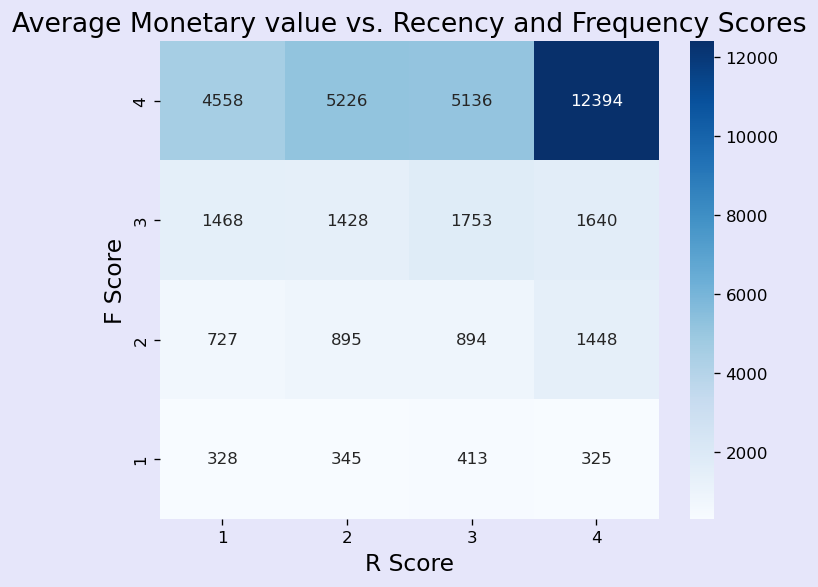

In [65]:
import seaborn as sns

#pivot table for the R vs. F score effect on monetary value
rfm_fr_Monetary = rfm.pivot_table(
    index = 'F_Score',
    columns = 'R_Score',
    values = 'Amount_Spent',
    aggfunc = 'mean', #the calculation we're doing on 'amount_spent
    observed=False
)

#reorder scores from low to high
rfm_fr_Monetary = rfm_fr_Monetary.loc[[4,3,2,1],[1,2,3,4]]

#heatmap of monetary value for R vs. F scores
fig1 = plt.figure(figsize=(6,5),dpi=120)
fig1.patch.set_facecolor('lavender')
ax1 = sns.heatmap(rfm_fr_Monetary, annot=True, fmt=".0f", cmap="Blues")
plt.title("Average Monetary value vs. Recency and Frequency Scores",fontsize=16)
ax1.set_xlabel("R Score",fontsize = 14)
ax1.set_ylabel("F Score",fontsize = 14)
plt.tight_layout()
plt.show()

Looking at heatmaps of how our individual RFM scores correlate with monetary value and purchase frequency, we see very clearly that:

* customers with more frequent purchases are more likely to spend more overall
* customers with more recent purchases are more likely to spend more overall (these are connected, as frequent customers are naturally more likely to have recent purchases)

We'll also look at how evenly distributed customers are in terms of total RFM score (3-12) and whether that correlates clearly with total monetary value:

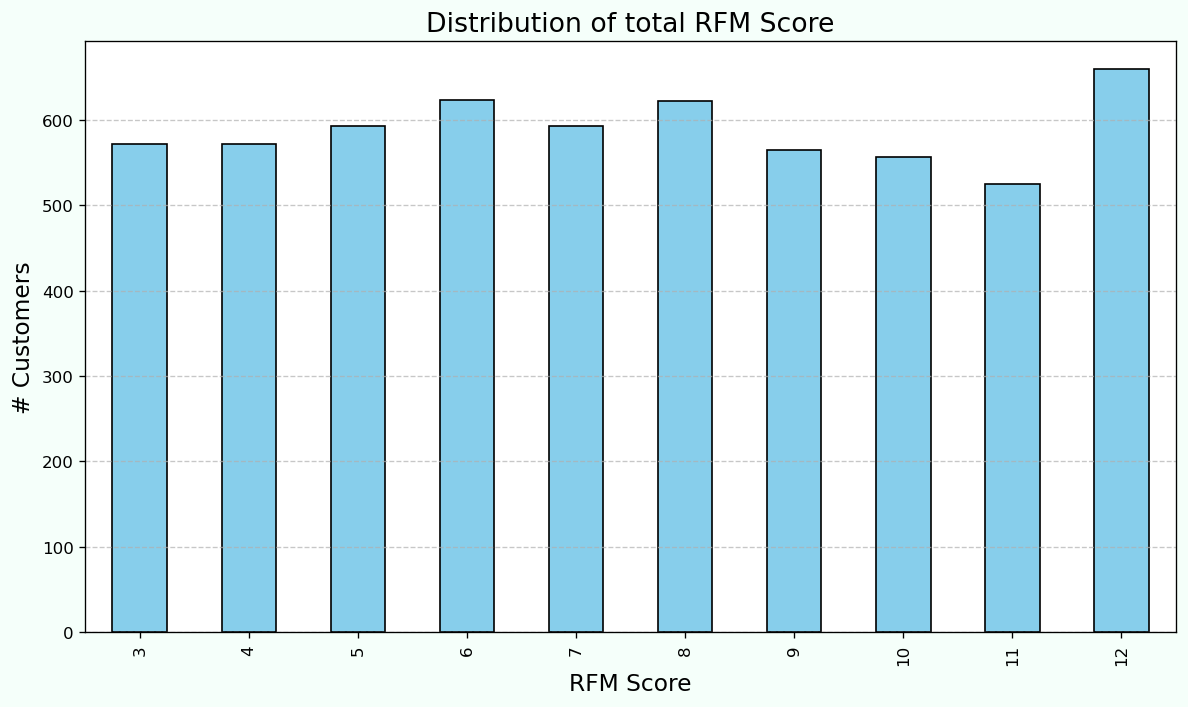

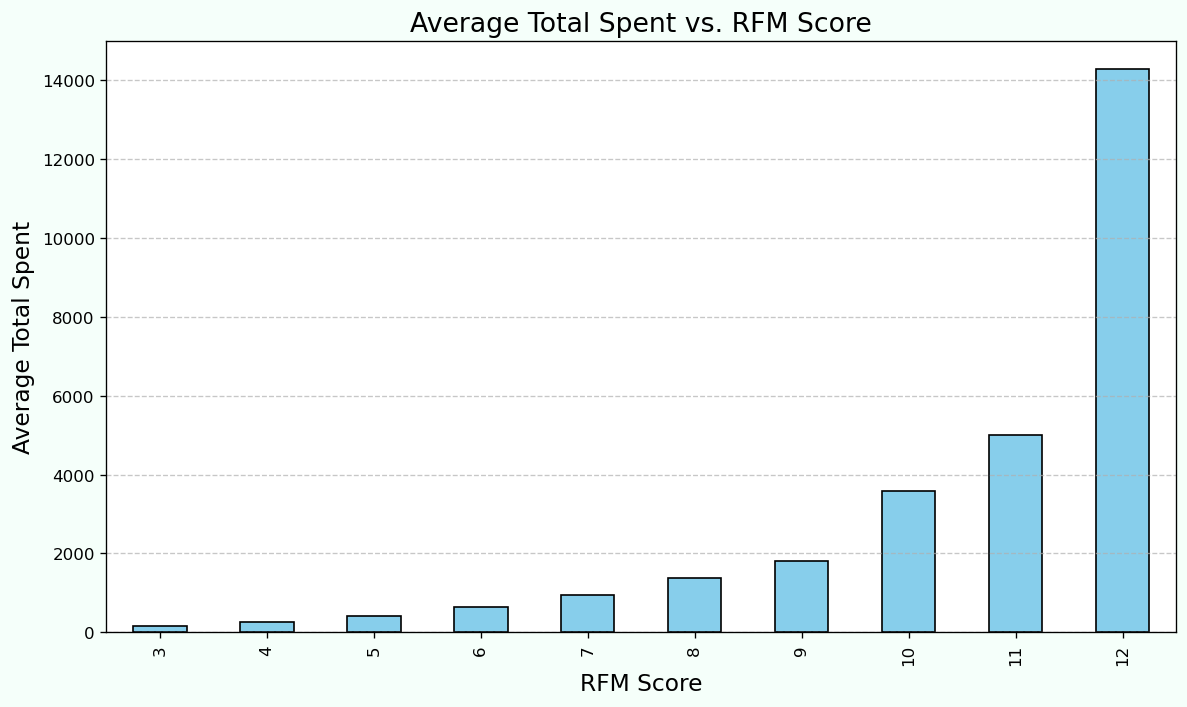

In [67]:
rfm_counts = rfm['RFM_Score'].value_counts().sort_index()
rfm_monetary = rfm.groupby('RFM_Score')['Amount_Spent'].mean()

fig = plt.figure(figsize=(10,6),dpi=120)
fig.patch.set_facecolor('mintcream')
ax = rfm_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of total RFM Score', fontsize=16)
plt.xlabel('RFM Score',fontsize=14)
plt.ylabel('# Customers', fontsize=14)
#plt.xticks(rotation=0)
plt.grid(axis='y',linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(10,6),dpi=120)
fig.patch.set_facecolor('mintcream')
ax = rfm_monetary.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Total Spent vs. RFM Score', fontsize=16)
plt.xlabel('RFM Score',fontsize=14)
plt.ylabel('Average Total Spent', fontsize=14)
#plt.xticks(rotation=0)
plt.grid(axis='y',linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

These plots demonstrate that:
1. Customers are relatively evenly distributed across scores 3 through 12
2. the RFM score clearly correlates with the amount individual customers are spending on the website. 

Next we'll see if we can use unsupervised clustering to group the customers into segments. We'll use KMeans from the sklearn library in order to do that. First we'll need to prepare and fit a chosen number of clusters onto the data:

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

#selecting values for clustering
rfm_clustering = rfm[['Recency','Frequency','Amount_Spent']].copy()

#scale the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_clustering) #scaling the values to be between 0 and 1

#use Kmeans and a choice number of clusters to categorize customers. random_state is chosen for reproducibility
kmeans = KMeans(n_clusters=4, random_state=27) #5 clusters
rfm['Clusters'] = kmeans.fit_predict(rfm_scaled) #fit data into clusters


And now we can plot the result in a 3-dimensions. We chose 4 clusters because the result appears to make the most conceptual sense. If you're running this notebook yourself, feel free to adjust n_clusters and redo this a few times to decide whether this choice was right.

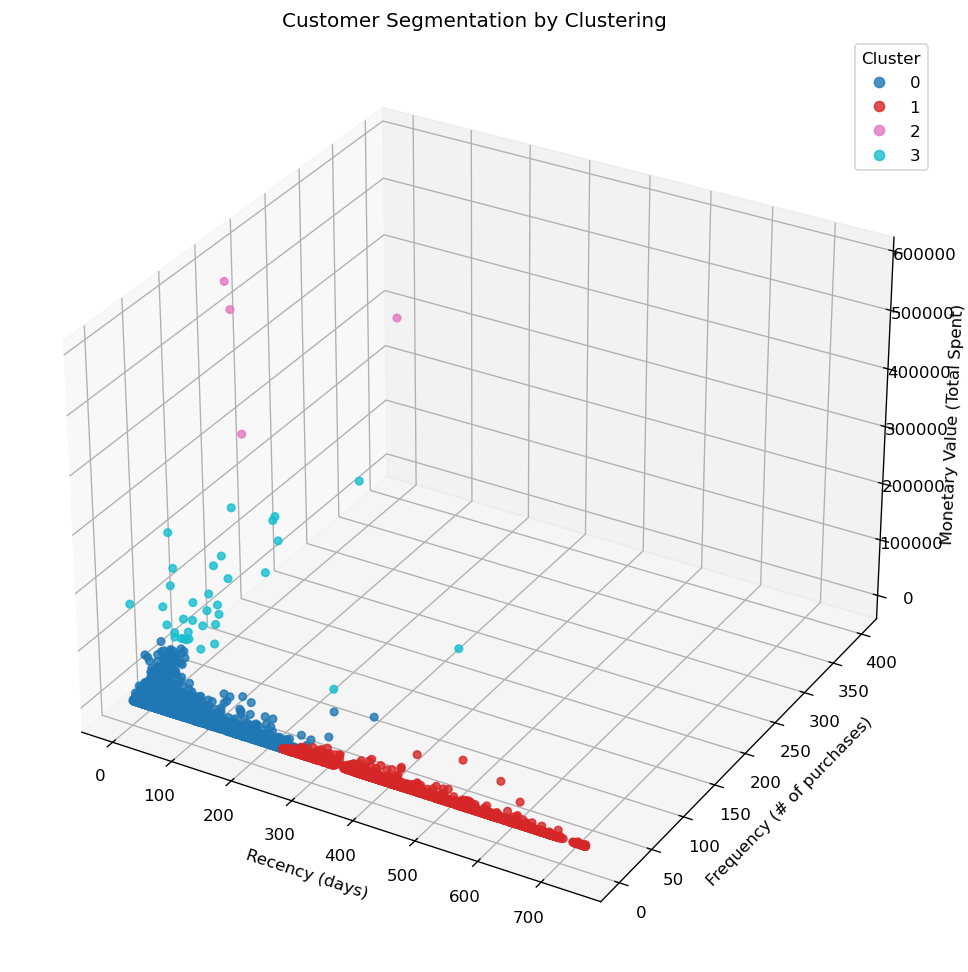

In [69]:
from mpl_toolkits.mplot3d import Axes3D

fig1 = plt.figure(figsize=(8,10),dpi=120)

ax1 = fig1.add_subplot(111, projection='3d')
scatter = ax1.scatter(
    rfm['Recency'], rfm['Frequency'], rfm['Amount_Spent'],
    c=rfm['Clusters'], cmap = 'tab10', s = 20, alpha = 0.8
)

ax1.set_xlabel('Recency (days)')
ax1.set_ylabel('Frequency (# of purchases)')
ax1.set_zlabel('Monetary Value (Total Spent)')
ax1.set_title('Customer Segmentation by Clustering')
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.tight_layout()

plt.show()

C:\Users\Owner\AppData\Local\Temp\ipykernel_33236\102104787.py:14: UserWarning: Adding colorbar to a different Figure <Figure size 960x1200 with 2 Axes> than <Figure size 1200x720 with 1 Axes> which fig.colorbar is called on.
  cbar = fig.colorbar(scatter, ax=ax2, shrink=0.5, aspect=10)


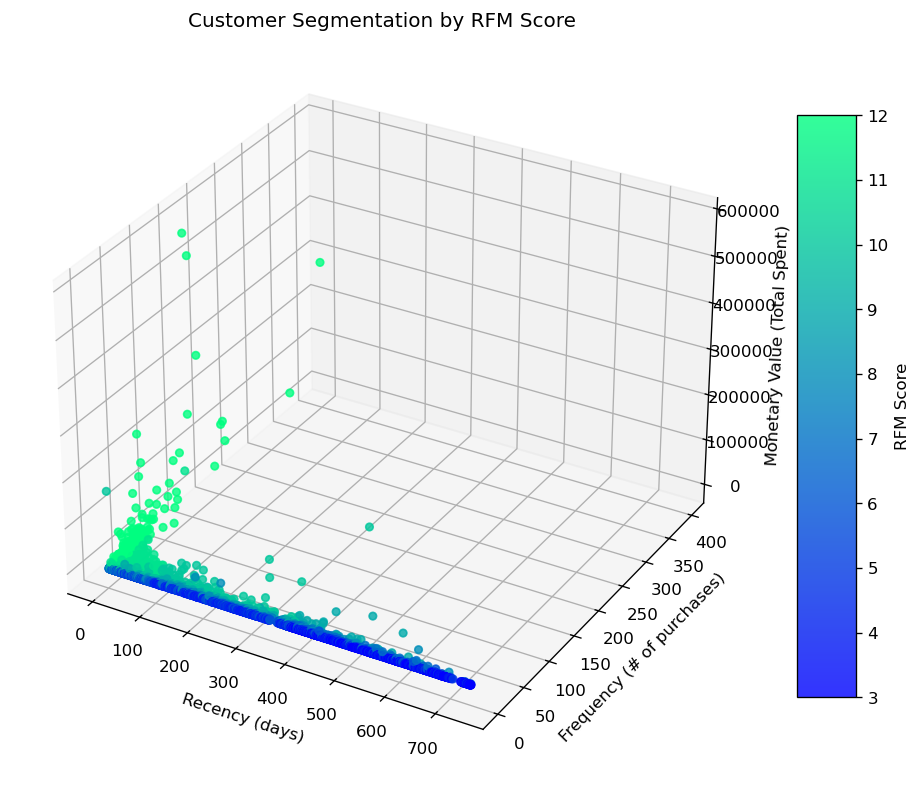

In [71]:
fig2 = plt.figure(figsize=(8,10),dpi=120)

ax2 = fig2.add_subplot(111, projection='3d')
scatter = ax2.scatter(
    rfm['Recency'], rfm['Frequency'], rfm['Amount_Spent'],
    c=rfm['RFM_Score'], cmap = 'winter', s = 20, alpha = 0.8
)

ax2.set_xlabel('Recency (days)')
ax2.set_ylabel('Frequency (# of purchases)')
ax2.set_zlabel('Monetary Value (Total Spent)')
ax2.set_title('Customer Segmentation by RFM Score')

cbar = fig.colorbar(scatter, ax=ax2, shrink=0.5, aspect=10)
cbar.set_label('RFM Score')
plt.tight_layout()
plt.show()

So we have a natural segmentation of the dataset using Kmeans clustering. Here are how I would describe each category:
* The red dots (bottom right) are customers that only made a few purchases and have not purchased anything for a while. These are low value customers unlikely to purchase from the website again.
* The dark blue dots (bottom left) are lower-value customers that have purchased more recently. Some of them have purchased slightly more and are worth more in terms of monetary value. These customers as a group could be worth marketing towards, in order to retain newer customers.
* The light blue dots are customers with mid-high montetary value who have purchased more recently (barring two customers in this group), and have spent more on the site than the first two groups. These are high-value customers worth keeping.
* The pink dots are ultra-high value customers, who have purchased recently, frequently and have spent large amounts of money on the site. These could be considered "VIP" customers.

## Pt 5: Key Insights and Recommendations

### Key Insights

1. **Overall Sales Trends**
    - The vast majority of revenue comes **from the United Kingdom** (about 85%), with other contries contributing significantly less
    - **Top-selling products**: the "Regency 3-tier cakestand", "Manual" and "Dotcom postage"
    - **Seasonal Spending Patterns**: sales boom in the pre-holiday season from september to november
      
2. **Customer Purchasing Behavior**
    - Most customers make few purchases per year with low average cost
    - Mean purchase quantity and revenue are higher than median values (high-value customers skew the data)
      
3. **RFM Analysis**
    - Customers are relatively **evenly distributed** between RFM scores 3-12
    - **Frequent** and **recent** customers spend more on average, with a strong correlation between RFM score and average monetary value.
    - RFM scores 10-12 can be considered **high-value customers**, generating a disproportionate share of the total revenue
    - see RFM heatmap and bar-charts for demonstration of the correlations between recency, frequency and monetary value
      
4. **Clustering (KMeans)**
    - **Cluster 1 (red)**: lower-value customers, with no recent or frequent purchasing
    - **Cluster 2 (darker blue)**: low to mid-value customers with high potential. Recent purchases and slightly higher spending indicate the possibility of retention
    - **Cluster 3 (lighter blue)**: high-value customers with higher frequency, recency and monetary value. These are the ideal consumers for any company. 
    - **Cluster 4 (pink)**: Ultra-high monetary value customers. These are outliers that could be considered VIPs to the company.
    - see 3D scatterplot for visualization of scattering and subsequent RFM scatterplot for comparison between the segmentation methods

### Recommendations

1. **Retention**
    - Engage **Cluster 4** and **Cluster 3** (high-value) customers (or RFM score 10-12 customers) with exclusive offers or loyalty programs
    - Implement retention campains for **Cluster 2** (low-value with recent purchases) (or RFM score 6-9) to encourage repeat purchasing and retain newer customers
      
2. **Marketing**
    - Promote **top-selling products** to mid and high-value customer clusters to maximize revenue

3. **Operational Suggestions**
    - Stock top-selling items prior to **September** to avoid going out of stock during peak purchasing season
    - Ensure supply of items favored by high-value customers is sufficient (since these segments of the customer base are more likely to also purchase in large quantities)
      
4. **Customer Acquisition**
    - Use attributes of the high-value clusters (or high RFM value customers) to inform **lookalike campaigns** in order to acquire customers that are likely to spend more
    - repeat analysis over time to identify changes in the customer base, high-value segments, etc...

## Pt 6: Conclusion

This analysis of the Online Retail II dataset highlights that a small proportion of customers make up the majority of revenue, as evidenced by the identification of higher-value customer segments. These segments were revealed using traditional RFM analysis and unsupervised learning in the form of Kmeans clustering. Both reveal a large number of low-value customers unlikely to purchase again, a large number of recent low to mid-value customers that could be retained with the proper marketing strategies, and a lower number of high-value customers responsible for a significant proportion of company income. Trends over the course of the year were also revealed, with sharp increases around the month of September and continuing through November for both years included in this dataset. 

Our recommendations based on these results included targeted retention and marketing campaigns to maintain and improve the value of the customer base, optimizing inventory and marketing of top products (particularly around high-revenue months of September-November), and optimizing strategies to acquire customers similar to current high-value customers. 
